<a href="https://colab.research.google.com/github/AfraAd/CSC413-Homeworks/blob/main/Fall25_Hw9_Transformer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 9 - Transformers Part II
CSC413/2516: Neural Networks and Deep Learning

As with previous homeworks, replace "#### Your Code ####" lines with your implementation.


Transformer architecture has been evolving since the seminal [``Attention Is All You Need''](https://arxiv.org/abs/1706.03762) paper by Vaswani et al. 2017.
In this homework, you will implement some of these changes, namely
1. Position Encodings (2.2 points)
2. Architecture Changes (2.3 points)
3. Architecture Detective (2 points)

# Set-up

In [1]:
import math
import random
from typing import Dict, Literal

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, random_split

SEED = 42


def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


set_seed()

## Dataset

We will work on a simple sequential dataset that shift the elements of the input sequence.

In [2]:
# don't change
data_args = {
    "num_samples": 1000,
    "seq_len": 32,
    "vocab_size": 20,
    "distance": 4,
}


class ShiftDataset(Dataset):
    """
    Shifts the elements of a sequence.
    """

    def __init__(self, num_samples=1000, seq_len=32, vocab_size=20, distance=4):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.distance = distance

        self.src = torch.randint(1, vocab_size, (num_samples, seq_len))
        self.tgt = torch.zeros_like(self.src)
        self.tgt[:, distance:] = self.src[:, :-distance]


    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return {"inputs": self.src[idx], "targets": self.tgt[idx]}


def visualize_dataset(dataset, num_examples: int = 4):
    for i in range(num_examples):
        batch = dataset[i]

        print(f"\nExample {i + 1}:")
        print(f"Source: {' | '.join([f'{i:4d}' for i in batch['inputs'].tolist()])}")
        print(f"Target: {' | '.join([f'{i:4d}' for i in batch['targets'].tolist()])}")


if __name__ == "__main__":
    set_seed()
    data = ShiftDataset(**data_args)
    visualize_dataset(data, 4)



Example 1:
Source:   16 |   14 |   12 |   15 |    3 |   15 |   16 |    7 |    6 |   14 |    3 |   16 |    4 |    4 |   18 |    8 |   11 |    9 |   18 |   18 |   14 |    5 |   17 |   11 |   15 |    9 |   11 |   10 |    7 |    7 |    9 |   17
Target:    0 |    0 |    0 |    0 |   16 |   14 |   12 |   15 |    3 |   15 |   16 |    7 |    6 |   14 |    3 |   16 |    4 |    4 |   18 |    8 |   11 |    9 |   18 |   18 |   14 |    5 |   17 |   11 |   15 |    9 |   11 |   10

Example 2:
Source:   11 |    4 |    4 |   10 |    5 |   19 |    5 |    1 |   11 |    1 |   12 |   16 |   11 |    6 |   12 |    8 |   10 |    5 |   11 |   11 |   11 |    1 |    9 |   16 |    9 |    3 |   15 |   19 |   13 |    9 |   14 |    7
Target:    0 |    0 |    0 |    0 |   11 |    4 |    4 |   10 |    5 |   19 |    5 |    1 |   11 |    1 |   12 |   16 |   11 |    6 |   12 |    8 |   10 |    5 |   11 |   11 |   11 |    1 |    9 |   16 |    9 |    3 |   15 |   19

Example 3:
Source:    3 |   17 |    2 |    5 |   12 |  

# Part 1 - Positional Embeddings (2.5 Points)

In class, we discussed various forms of position embeddings for self-attention in Transformers. In this part you will implement four positional embeddings, each worth 0.5 points:

1. Sinusodial encoding (Vaswani et al. 2017) --- The original Transformer's absolute position encoding. The original Transformer used fixed sinusoidal functions to encode absolute positions:
$$\text{PE}(pos, 2i) = \sin(pos / 10000^{2i/d_{model}})$$
$$\text{PE}(pos, 2i+1) = \cos(pos / 10000^{2i/d_{model}})$$
where pos is the position and i is the dimension. These encodings are added to the input embeddings before the first transformer layer.

2. Relative bias encoding in [T5](https://arxiv.org/abs/1910.10683) --- Learned relative position biases. T5 introduced **relative position biases** that are added directly to attention scores rather than to embeddings. The key innovation is **bucketing**: relative distances are grouped into buckets, with exact positions for small distances and logarithmic spacing for larger distances.
There is a single set of attention "bias" scalars ($e_\Delta$) shared across all layers. Each attention head has its own set of bias values. The offsets in the bias values are logarithmically spaced, and there are 32 total bias values.
- **Bucketing scheme**:
  - First half of buckets: exact positions (0, 1, 2, ..., 15)
  - Second half: logarithmically spaced (16-32, 32-64, 64-128, ...)
The bias is added to attention logits: $\text{softmax}(\frac{QK^T}{\sqrt{d}} + \text{bias})$

We provide more explanation on T5 buckets later in the homework.

3. [RoPE (Rotary Position Embedding)](https://arxiv.org/abs/2104.09864) (Su et al. 2021) --- Rotation-based relative encoding
RoPE applies position-dependent rotations to query and key vectors in 2D subspaces. For a position $m$, pairs of dimensions are rotated by angle $m\theta_i$, where $\theta_i = 10000^{-2i/d}$. The rotation can be expressed as:
$$\begin{bmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{bmatrix} \begin{bmatrix} q_{2i} \\ q_{2i+1} \end{bmatrix}$$

4. [ALIBI](https://arxiv.org/abs/2108.12409) (Press et al. 2021) --- Linear position relatigve position bias. Like the T5 relative position bias, ALiBi adds a simple linear bias based on distance: $-m \cdot (i - j)$, where $m$ is a learned head-specific scalar slope parameter and $(i-j)$ is the distance between positions.



In [3]:
def sinusoidal_position_encoding(seq_len: int, d_model: int) -> torch.Tensor:
    res = torch.zeros((seq_len, d_model))
    ########################### YOUR CODE ###################################
    ## TODO: Compute sinusoidal position encodings
    ## PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    ## PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    ## Hint: Returns tensor of shape (seq_len, d_model) containing position encodings
    #########################################################################
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)

    div_term = torch.exp(
        torch.arange(0, d_model, 2, dtype=torch.float32) *
        -(math.log(10000.0) / d_model)
    )

    res[:, 0::2] = torch.sin(position * div_term)
    res[:, 1::2] = torch.cos(position * div_term)

    return res


**T5 Buckets Explanation**

- 1: Split buckets for bidirectional distances
  - `bidirectional=True`, so half of the buckets are for negative relative positions and half for positive relative positions.  
  - `num_buckets = 8` $\to$ 4 buckets for negative, 4 buckets for positive.  

- 2: Map negative positions
  - Negative relative positions (`query < key`) are mapped to the lower half of the buckets: `[0, 1, 2,3]`.  
  - Zero distance (`query == key`) is treated as the smallest positive distance (usually mapped to the first (0) positive bucket).  

- 3: Map positive positions
  - Positive relative positions (`query > key`) are mapped to the upper half of the buckets: `[4, 5, 6, 7]`.  

- 4: Exact vs logarithmic buckets
  - Small distances (i.e., distances < num_buckets//2) are assigned to exact buckets.  
  - Larger distances (beyond this range) are mapped logarithmically to the remaining buckets, which allows covering larger relative positions efficiently without needing a bucket for every possible distance.

  We provide you with a sanity check in the second cell and you can find more test cases on Markus.


In [4]:
def t5_relative_position_bucket(
    relative_position: torch.Tensor,
    bidirectional: bool = True,
    num_buckets: int = 32,
    max_distance: int = 128,
) -> torch.Tensor:
    """
    Helper function
    Translate relative positions to bucket indices.

    Buckets are divided into two parts:
    1. Exact buckets: for small relative distances  (0, 1, 2, ..., num_buckets//2 - 1)
    2. Logarithmic buckets: for larger relative distances up to max_distance

    If bidirectional=True, positive and negative positions get separate sets of buckets.

    Args:
        relative_position: Tensor of relative positions (query_pos - key_pos)
        bidirectional: If True, use separate buckets for positive/negative distances
        num_buckets: Total number of buckets,
            You can assume num_buckets is always even and larger than 2
        max_distance: Maximum distance to consider
    """
    relative_buckets = torch.zeros((relative_position.shape), dtype=torch.int32)

    # 1: Handle bidirectional positions
    if bidirectional:
        # Split buckets: half for negative, half for positive
        num_buckets //= 2
        # Add offset for positive positions (they go in upper half)
        relative_buckets += (relative_position > 0).to(torch.int32) * num_buckets
        # Work with absolute distances from now on
        relative_position = torch.abs(relative_position)
    else:
        # For unidirectional (causal), only keep non-positive distances
        # Clip positive values to 0 (future positions not allowed in decoder)
        relative_position = torch.clamp(-relative_position, min=0)

    # 2: Assign small distances to exact buckets
    # Half of num_buckets are for exact small distances
    max_exact = num_buckets // 2
    is_small = relative_position < max_exact

    # 3: Logarithmic buckets for large distances
    # For distances >= max_exact, use logarithmic spacing
    # Clamp the relative position to max_exact (lower bound) but don't clamp upper
    relative_position_if_large = torch.clamp(
        relative_position.float(),
        min=max_exact
    )

    # Logarithmic bucketing formula
    # Maps [max_exact, max_distance] to [max_exact, num_buckets-1]
    val_if_large = max_exact + (
        torch.log(relative_position_if_large / max_exact) /
        math.log(max_distance / max_exact) *
        (num_buckets - max_exact)
    ).to(torch.int32)

    # Clip to maximum bucket index
    val_if_large = torch.clamp(val_if_large, max=num_buckets - 1)

    # Combine: use exact buckets for small, logarithmic for large
    relative_buckets += torch.where(is_small, relative_position, val_if_large)

    return relative_buckets


def t5_relative_position_bias_with_values(
    query_len: int,
    key_len: int,
    bias_values: torch.Tensor,  # (num_heads, num_buckets) - learned parameters
    num_buckets: int = 32,
    max_distance: int = 128,
    bidirectional: bool = True,
) -> torch.Tensor:
    """
    Compute T5-style relative position biases using PROVIDED bias values.
    """
    # Create position matrices
    query_positions = torch.arange(query_len).unsqueeze(1)  # (query_len, 1)
    key_positions = torch.arange(key_len).unsqueeze(0)      # (1, key_len)

    # Compute relative positions: query - key
    # Broadcasting: (query_len, 1) - (1, key_len) -> (query_len, key_len)
    relative_position = query_positions - key_positions

    # Convert to buckets
    buckets = t5_relative_position_bucket(
        relative_position,
        bidirectional=bidirectional,
        num_buckets=num_buckets,
        max_distance=max_distance,
    )

    # Use the provided learned bias values
    res = bias_values[:, buckets]  # (num_heads, query_len, key_len)
    return res

In [5]:
## sanity check
if __name__ == "__main__":
    seq_len_ = 5
    num_buckets_ = 8
    relative_position = torch.tensor([
        [ 0, -1, -2, -3, -4],
        [ 1,  0, -1, -2, -3],
        [ 2,  1,  0, -1, -2],
        [ 3,  2,  1,  0, -1],
        [ 4,  3,  2,  1,  0],
    ])


    buckets = t5_relative_position_bucket(relative_position, bidirectional=True,
                                          num_buckets=num_buckets_, max_distance=3)
    expected = torch.tensor([[0, 1, 2, 3, 3],
        [5, 0, 1, 2, 3],
        [6, 5, 0, 1, 2],
        [7, 6, 5, 0, 1],
        [7, 7, 6, 5, 0]], dtype=torch.int32)
    assert torch.allclose(buckets, expected)

In [6]:
def alibi_bias(query_len: int, key_len: int, num_heads: int = 8) -> torch.Tensor:
    """
    Compute ALiBi position biases.
    Returns:
        Tensor of shape (num_heads, query_len, key_len) containing linear biases
    """
    res = torch.zeros((num_heads, query_len, key_len))

    # 1. Compute slopes for each head: 2^(-8*(h+1)/num_heads)
    # Different heads get different slopes (geometric sequence)
    head_indices = torch.arange(1, num_heads + 1, dtype=torch.float32)  # [1, 2, 3, ..., num_heads]
    slopes = torch.pow(2, -8 * head_indices / num_heads)  # 2^(-8*h/num_heads)
    slopes = slopes.unsqueeze(1).unsqueeze(2)  # Shape: (num_heads, 1, 1) for broadcasting

    # 2. Create distance matrix: relative_positions_{ij} = (i - j)
    query_positions = torch.arange(query_len, dtype=torch.float32).unsqueeze(1)  # (query_len, 1)
    key_positions = torch.arange(key_len, dtype=torch.float32).unsqueeze(0)  # (1, key_len)

    # Broadcasting: (query_len, 1) - (1, key_len) -> (query_len, key_len)
    relative_positions = query_positions - key_positions  # (query_len, key_len)
    relative_positions = relative_positions.unsqueeze(0)  # (1, query_len, key_len)

    # 3. Apply slopes: -slope * distance for each head
    res = -slopes * relative_positions  # (num_heads, query_len, key_len)

    return res


In [7]:
def apply_rotary_position_embedding(
    x: torch.Tensor,
    positions: torch.Tensor,
) -> torch.Tensor:
    """
    Apply rotary position embedding to input tensor.
    Args:
        x: Input tensor of shape (..., seq_len, dim)
        positions: Position indices of shape (seq_len,)

    Returns:
        Tensor of same shape as x with rotary embeddings applied
    """
    *batch_dims, seq_len, dim = x.shape

    # 1. Compute rotation frequencies: theta_i = 10000^(-2i/dim)
    # i goes from 0, 1, 2, ..., dim//2 - 1 (for each pair)
    i = torch.arange(0, dim, 2, dtype=torch.float32, device=x.device)
    theta = torch.pow(10000.0, -i / dim)  # Shape: (dim//2,)

    # 2. Compute angles: m * theta_i for each position m
    # positions: (seq_len,), theta: (dim//2,)
    # We want: (seq_len, dim//2)
    positions = positions.float().unsqueeze(1)  # (seq_len, 1)
    theta = theta.unsqueeze(0)  # (1, dim//2)
    angles = positions * theta  # Broadcasting: (seq_len, dim//2)

    # Compute cos and sin for the rotation
    cos_angles = torch.cos(angles)  # (seq_len, dim//2)
    sin_angles = torch.sin(angles)  # (seq_len, dim//2)

    # Add batch dimensions for broadcasting
    for _ in batch_dims:
        cos_angles = cos_angles.unsqueeze(0)
        sin_angles = sin_angles.unsqueeze(0)

    # 3. Reshape x into pairs: (..., seq_len, dim//2, 2)
    x_reshaped = x.view(*batch_dims, seq_len, dim // 2, 2)

    # Extract the two elements of each pair
    x1 = x_reshaped[..., 0]  # (..., seq_len, dim//2) - even indices
    x2 = x_reshaped[..., 1]  # (..., seq_len, dim//2) - odd indices

    # 4. Apply rotation matrix to each pair
    # Rotation matrix: [cos  -sin] [x1]
    #                  [sin   cos] [x2]
    # Result: [x1*cos - x2*sin]
    #         [x1*sin + x2*cos]

    rotated_x1 = x1 * cos_angles - x2 * sin_angles
    rotated_x2 = x1 * sin_angles + x2 * cos_angles

    # 5. Reshape back to original shape
    # Stack the rotated pairs back together
    res = torch.stack([rotated_x1, rotated_x2], dim=-1)  # (..., seq_len, dim//2, 2)
    res = res.view(*batch_dims, seq_len, dim)  # (..., seq_len, dim)

    return res


## Part 2 - Implement the transformer

- Pre vs. post layernorm (0.5 points)
- Norm type: layernorm and rmsnorm (0.5 points each)
- Correct transformer implementation (0.8 points)

In [8]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization (used in LLaMA)"""

    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        # 1. Compute x^2
        x_squared = x.pow(2)

        # 2. Compute mean of x^2 across the last dimension (feature dimension)
        mean_squared = x_squared.mean(dim=-1, keepdim=True)

        # 3. Compute RMS: sqrt(mean(x^2) + eps)
        rms = torch.sqrt(mean_squared + self.eps)

        # 4. Normalize: x / RMS
        normalized = x / rms

        # 5. Apply learnable scale (weight)
        rms = self.weight * normalized

        return rms


class LayerNorm(nn.Module):
    """
    Layer Normalization (Ba et al., 2016)

    Normalizes across the feature dimension:
    y = gamma * (x - mean) / sqrt(var + eps) + beta

    Used in original Transformer (Vaswani et al., 2017)
    """

    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))  # gamma
        self.bias = nn.Parameter(torch.zeros(d_model))  # beta

    def forward(self, x):
        # 1. Compute mean across feature dimension (dim=-1)
        mean = x.mean(dim=-1, keepdim=True)

        # 2. Compute variance across feature dimension
        # var = E[(x - mean)^2]
        variance = ((x - mean) ** 2).mean(dim=-1, keepdim=True)

        # 3. Normalize: (x - mean) / sqrt(var + eps)
        normalized = (x - mean) / torch.sqrt(variance + self.eps)

        # 4. Apply affine transformation: weight * normalized + bias
        res = self.weight * normalized + self.bias

        return res

In [9]:
class TinyTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=64,
        nhead=4,
        num_layers=2,
        max_len=128,
        pos_encoding="rope",
        num_t5_buckets: int = 32,
        norm_type: Literal["rmsnorm", "layernorm"] = "layernorm",
        pre_norm: bool = True,
    ):
        super().__init__()
        self.d_model = d_model
        self.pos_encoding_type = pos_encoding
        self.max_len = max_len

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList(
            [
                TransformerLayer(d_model, nhead, pos_encoding, norm_type, pre_norm)
                for _ in range(num_layers)
            ]
        )
        self.output = nn.Linear(d_model, vocab_size)

        # Create t5_bias if pos_encoding is t5
        # T5 biases should be learnable parameters of shape (nhead, num_t5_buckets)
        self.t5_bias = None
        if pos_encoding == "t5":
            self.t5_bias = nn.Parameter(torch.zeros(nhead, num_t5_buckets))

    def forward(self, x):
        x = self.embedding(x)

        # Add sinusoidal position encodings if pos_encoding_type is "sinusoidal"
        if self.pos_encoding_type == "sinusoidal":
            seq_len = x.size(1)
            # Get sinusoidal encodings and reshape to (1, seq_len, d_model)
            pos_enc = sinusoidal_position_encoding(seq_len, self.d_model)
            pos_enc = pos_enc.unsqueeze(0).to(x.device)  # (1, seq_len, d_model)
            x = x + pos_enc

        # Apply transformer layers
        for layer in self.layers:
            x = layer(x, t5_biases=self.t5_bias)

        return self.output(x)  # (batch, seq_len, vocab_size)

    @staticmethod
    def loss_fn(y_hat: torch.Tensor, y: torch.Tensor):
        # Implement cross-entropy loss
        # y_hat shape: (batch, seq_len, vocab_size)
        # y shape: (batch, seq_len) with class labels

        # Reshape for cross_entropy: (batch * seq_len, vocab_size) and (batch * seq_len)
        y_hat_flat = y_hat.view(-1, y_hat.size(-1))  # (batch*seq_len, vocab_size)
        y_flat = y.view(-1)  # (batch*seq_len)

        res = F.cross_entropy(y_hat_flat, y_flat)
        return res


class TransformerLayer(nn.Module):
    def __init__(
        self,
        d_model,
        nhead,
        pos_encoding="rope",
        norm_type: Literal["layernorm", "rmsnorm"] = "layernorm",
        pre_norm: bool = True,
    ):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        self.pos_encoding = pos_encoding

        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # Initialize normalization layers based on norm_type
        if norm_type == "layernorm":
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)
        elif norm_type == "rmsnorm":
            self.norm1 = RMSNorm(d_model)
            self.norm2 = RMSNorm(d_model)
        else:
            raise ValueError(f"Only norms available are RMSNorm and LayerNorm")

        self.pre_norm = pre_norm

        # Create feed forward layers
        # Linear -> GeLU -> Linear, FFN inner_dimension should be 4 * d_model
        ffn_dim = 4 * d_model
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_dim),
            nn.GELU(),
            nn.Linear(ffn_dim, d_model)
        )

    def forward(self, x, t5_biases):
        # Implement pre-norm or post-norm architecture
        # Pre-norm (modern): x = x + sublayer(norm(x))
        # Post-norm (original): x = norm(x + sublayer(x))

        if self.pre_norm:
            # Pre-norm: normalize before sublayer
            # Attention block
            x = x + self.self_attention(self.norm1(x), t5_biases)
            # FFN block
            x = x + self.ffn(self.norm2(x))
        else:
            # Post-norm: normalize after residual
            # Attention block
            x = self.norm1(x + self.self_attention(x, t5_biases))
            # FFN block
            x = self.norm2(x + self.ffn(x))

        return x

    def self_attention(self, x, t5_biases):
        batch_size, seq_len, _ = x.shape

        # Project to Q, K, V
        qkv = self.qkv_proj(x)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)

        # Apply RoPE if pos_encoding is "rope"
        if self.pos_encoding == "rope":
            positions = torch.arange(seq_len, device=x.device)
            # Apply rotary embeddings to Q and K
            # Reshape to (batch * nhead, seq_len, head_dim)
            q_reshaped = q.contiguous().view(batch_size * self.nhead, seq_len, self.head_dim)
            k_reshaped = k.contiguous().view(batch_size * self.nhead, seq_len, self.head_dim)

            # Apply RoPE (now it applies to head_dim for each head separately)
            q_reshaped = apply_rotary_position_embedding(q_reshaped, positions)
            k_reshaped = apply_rotary_position_embedding(k_reshaped, positions)

            # Reshape back
            q = q_reshaped.view(batch_size, self.nhead, seq_len, self.head_dim)
            k = k_reshaped.view(batch_size, self.nhead, seq_len, self.head_dim)

        # Compute attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim**0.5)

        # Add position biases based on pos_encoding type
        if self.pos_encoding == "alibi":
            # ALiBi: Use alibi_bias(seq_len, seq_len, self.nhead)
            bias = alibi_bias(seq_len, seq_len, self.nhead).to(scores.device)
            scores = scores + bias.unsqueeze(0)  # Add batch dimension

        elif self.pos_encoding == "t5":
            # T5: Use t5_relative_position_bias_with_values
            bias = t5_relative_position_bias_with_values(
                seq_len, seq_len, t5_biases
            ).to(scores.device)
            scores = scores + bias.unsqueeze(0)  # Add batch dimension

        # Apply causal mask
        mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device))
        scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0) == 0, float("-inf"))

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v)

        # Reshape back
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.out_proj(out)

## Trainer (0.2 points)
Implement the trainer, this will be quite similar to Hw 6 and 7 trainer with small tweaks:
- We won't use attention_mask
- We will keep track of accuracy

In [10]:
class Trainer:
    def __init__(
        self,
        max_epochs,
        batch_size,
        gradient_clip_val=1,
        device="cpu",
        print_every: int = 5,
    ):
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.gradient_clip_val = gradient_clip_val
        self.device = device
        self.train_loss = []  # record the avg. batch loss every epoch
        self.valid_loss = []  # record the avg. batch loss every epoch
        self.train_acc = []  # record the avg. batch accuracy every epoch
        self.val_acc = []  # record the avg. batch accuracy every epoch
        self.print_every = print_every

    @staticmethod
    def clip_gradients(model, max_norm):
        if not max_norm:
            return
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

    def get_dataloader(self, data):
        g = torch.Generator()
        g.manual_seed(SEED)
        train_size = int(0.8 * len(data))
        train_data, val_data = random_split(data, [train_size, len(data) - train_size], generator=g)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True, generator=g)
        valid_loader = DataLoader(val_data, batch_size=self.batch_size, shuffle=False, generator=g)

        return train_loader, valid_loader

    def fit(self, model, data, optimizer=None):
        model.to(self.device)
        if optimizer is None:
            optimizer = torch.optim.SGD(model.parameters(), lr=model.lr)
        train_loader, valid_loader = self.get_dataloader(data)

        for epoch in range(self.max_epochs):
            model.train()
            train_loss = 0
            valid_loss = 0
            correct = 0
            total = 0

            # Training loop
            for batch in train_loader:
                # Extract from dictionary
                X = batch["inputs"].to(self.device)
                Y = batch["targets"].to(self.device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                y_hat = model(X)  # (batch_size, seq_len, vocab_size)

                # Compute loss
                loss = model.loss_fn(y_hat, Y)

                # Backward pass
                loss.backward()

                # Clip gradients
                self.clip_gradients(model, self.gradient_clip_val)

                # Update weights
                optimizer.step()

                # Record loss
                train_loss += loss.item()

                # Compute accuracy
                # Get predicted class (argmax over vocab dimension)
                predictions = y_hat.argmax(dim=-1)  # (batch_size, seq_len)
                correct += (predictions == Y).sum().item()
                total += Y.numel()  # Total number of tokens

            assert 0.0 <= correct / total <= 1.0, "Accuracy should be between 0 and 1"
            self.train_loss.append(train_loss / len(train_loader))
            self.train_acc.append(correct / total)

            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                # Validation loop
                for batch in valid_loader:
                    X = batch["inputs"].to(self.device)
                    Y = batch["targets"].to(self.device)

                    # Forward pass only (no gradients)
                    y_hat = model(X)

                    # Compute loss
                    loss = model.loss_fn(y_hat, Y)
                    valid_loss += loss.item()

                    # Compute accuracy
                    predictions = y_hat.argmax(dim=-1)
                    val_correct += (predictions == Y).sum().item()
                    val_total += Y.numel()

            self.valid_loss.append(valid_loss / len(valid_loader))
            self.val_acc.append(val_correct / val_total)

            if (epoch + 1) % self.print_every == 0:
                print(
                    f"Epoch {epoch + 1} train loss: {self.train_loss[-1]:.5f},\t train acc: {self.train_acc[-1]:.5f}\n\tvalidation loss {self.valid_loss[-1]:.5f}, val acc: {self.val_acc[-1]:.5f} "
                )

    def predict(self, model, dataloader):
        """
        Generate predictions on a dataset.
        Returns:
            predictions, targets, avg_loss, avg_acc
        """
        model.to(self.device)
        model.eval()

        all_predictions = []
        all_targets = []
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch in dataloader:
                # Extract batch data
                X = batch["inputs"].to(self.device)
                Y = batch["targets"].to(self.device)

                # Forward pass
                y_hat = model(X)  # (batch_size, seq_len, vocab_size)

                # Compute loss
                loss = model.loss_fn(y_hat, Y)
                total_loss += loss.item()
                num_batches += 1

                # Get predictions (argmax over vocabulary)
                predictions = y_hat.argmax(dim=-1)  # (batch_size, seq_len)

                # Flatten and store predictions and targets
                all_predictions.append(predictions.view(-1))  # Flatten to 1D
                all_targets.append(Y.view(-1))  # Flatten to 1D

        # Concatenate all predictions and targets
        predictions = torch.cat(all_predictions, dim=0)
        targets = torch.cat(all_targets, dim=0)
        avg_acc = (predictions == targets).float().mean().item()

        avg_loss = total_loss / num_batches
        return predictions, targets, avg_loss, avg_acc

In [11]:
# don't change
def visualize_training(
    trainer, data, positional_encoding_type, model=None, vocab_size=20, title=""
):
    tr, val = trainer.get_dataloader(data)
    preds, targets, avg_loss, avg_acc = trainer.predict(model, val)

    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(
        f"{title} - Val Acc: {avg_acc:.4f}",
        fontsize=14,
        fontweight="bold",
    )

    # 1. Confusion matrix
    cm = confusion_matrix(
        targets.flatten(), preds.flatten(), labels=np.arange(1, vocab_size)
    )
    im = axs[0].imshow(cm, cmap="Blues", aspect="auto")
    axs[0].set_xlabel("Predicted Token", fontsize=11)
    axs[0].set_ylabel("Target Token", fontsize=11)
    axs[0].set_title("Confusion Matrix", fontsize=12)
    plt.colorbar(im, ax=axs[0], fraction=0.046)

    # 2. Training and validation loss
    axs[1].plot(trainer.train_loss, label="Train Loss", linewidth=2)
    axs[1].plot(trainer.valid_loss, label="Val Loss", linewidth=2)
    axs[1].set_ylabel("Loss", fontsize=11)
    axs[1].set_xlabel("Epoch", fontsize=11)
    axs[1].set_title("Training & Validation Loss", fontsize=12)
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    # 3. Training and validation accuracy
    axs[2].plot(trainer.train_acc, label="Train Acc", linewidth=2)
    axs[2].plot(trainer.val_acc, label="Val Acc", linewidth=2)
    axs[2].set_ylabel("Accuracy", fontsize=11)
    axs[2].set_xlabel("Epoch", fontsize=11)
    axs[2].set_title("Training & Validation Accuracy", fontsize=12)
    axs[2].set_ylim([0, 1.05])
    axs[2].legend()
    axs[2].grid(alpha=0.3)

    # 4. Positional encoding visualization (if applicable)
    if positional_encoding_type == "t5" and model is not None:
        # Visualize learned T5 biases
        seq_len = 64
        t5_bias = t5_relative_position_bias_with_values(
            seq_len, seq_len, model.t5_bias.detach().cpu()
        )
        im = axs[3].imshow(
            t5_bias[0].numpy(), cmap="RdBu", aspect="auto", vmin=-3, vmax=3
        )
        axs[3].set_xlabel("Key Position", fontsize=11)
        axs[3].set_ylabel("Query Position", fontsize=11)
        axs[3].set_title("Learned T5 Bias (Head 0)", fontsize=12)
        axs[3].plot([0, seq_len - 1], [0, seq_len - 1], "k--", linewidth=1, alpha=0.3)
        plt.colorbar(im, ax=axs[3], fraction=0.046)

    elif positional_encoding_type == "alibi":
        # Visualize ALiBi biases
        seq_len = 64
        alibi = alibi_bias(seq_len, seq_len, model.layers[0].nhead if model else 8)
        im = axs[3].imshow(alibi[0].numpy(), cmap="RdBu", aspect="auto")
        axs[3].set_xlabel("Key Position", fontsize=11)
        axs[3].set_ylabel("Query Position", fontsize=11)
        axs[3].set_title("ALiBi Bias (Head 0)", fontsize=12)
        axs[3].plot([0, seq_len - 1], [0, seq_len - 1], "k--", linewidth=1, alpha=0.3)
        plt.colorbar(im, ax=axs[3], fraction=0.046)

    elif positional_encoding_type == "rope" and model is not None:
        # Visualize RoPE attention pattern
        seq_len = 64
        d_model = model.d_model
        q = torch.randn(1, seq_len, d_model)
        k = torch.randn(1, seq_len, d_model)
        positions = torch.arange(seq_len)
        q_rope = apply_rotary_position_embedding(q, positions)
        k_rope = apply_rotary_position_embedding(k, positions)
        scores = torch.matmul(q_rope, k_rope.transpose(-2, -1)) / np.sqrt(d_model)
        im = axs[3].imshow(scores[0].numpy(), cmap="RdBu", aspect="auto")
        axs[3].set_xlabel("Key Position", fontsize=11)
        axs[3].set_ylabel("Query Position", fontsize=11)
        axs[3].set_title("RoPE Attention Pattern", fontsize=12)
        axs[3].plot([0, seq_len - 1], [0, seq_len - 1], "k--", linewidth=1, alpha=0.3)
        plt.colorbar(im, ax=axs[3], fraction=0.046)

    elif positional_encoding_type == "sinusoidal":
        # Visualize sinusoidal encoding
        seq_len = 64
        sin_enc = sinusoidal_position_encoding(seq_len, model.d_model if model else 64)
        im = axs[3].imshow(sin_enc.T.numpy(), cmap="RdBu", aspect="auto")
        axs[3].set_xlabel("Position", fontsize=11)
        axs[3].set_ylabel("Embedding Dimension", fontsize=11)
        axs[3].set_title("Sinusoidal Encoding", fontsize=12)
        plt.colorbar(im, ax=axs[3], fraction=0.046)

    fig.tight_layout()
    return fig

### Train the models and examine the output
Unlike previous homeworks, we won't ask you to optimize the hyper-parameters. If your implementation is correct, with the given hyper-parameters, you should achieve >0.8 accuracy with sinussoidal, T5, and RoPE. ~0.3 with no encodings and ALiBi.

(ungraded)

After running the training code and examining the visualizations, answer the following question:

1. Can the model learn the shift task without any position encoding (pos_encoding="none")?
   Why or why not? What does this tell you about the importance of position information?
1. Why does the ALiBi model perform poorly? What tweaks could have improved the performance?
1. Are certain positional embeddings better suited for certain datasets? (You can also experiment with three other datasets included in the next cells).
1. Examine the encoding heatmaps (4th column). Describe the patterns, are they similar to how you would expect them to be?

**Task-specific**
1. The shift task requires outputting token 0 for the first `distance` positions.
   Can you identify if the model learned this from the confusion matrix?
1. The shift task is a "relative position" task (copy from distance=4 back).
   Explain why relative position encodings (RoPE, T5, ALiBi) should theoretically
   perform better than absolute encodings (Sinusoidal) on this task.
1. If you trained on sequences of length 16, which encoding would you expect to
   perform best on sequences of length 32? Why?


==============================none==============================
Epoch 5 train loss: 2.63372,	 train acc: 0.18164
	validation loss 2.55702, val acc: 0.20688 
Epoch 10 train loss: 2.17551,	 train acc: 0.27590
	validation loss 2.19638, val acc: 0.26344 
Epoch 15 train loss: 2.00141,	 train acc: 0.29961
	validation loss 2.05733, val acc: 0.27766 
Epoch 20 train loss: 1.92142,	 train acc: 0.30992
	validation loss 2.00275, val acc: 0.28266 
Epoch 25 train loss: 1.86625,	 train acc: 0.31438
	validation loss 1.97546, val acc: 0.28469 
==============================sinusoidal==============================
Epoch 5 train loss: 2.44897,	 train acc: 0.24918
	validation loss 2.41699, val acc: 0.25000 
Epoch 10 train loss: 1.92381,	 train acc: 0.32832
	validation loss 1.90404, val acc: 0.32859 
Epoch 15 train loss: 1.32308,	 train acc: 0.48945
	validation loss 1.25257, val acc: 0.51062 
Epoch 20 train loss: 0.01223,	 train acc: 0.99988
	validation loss 0.00931, val acc: 0.99984 
Epoch 25 train loss:

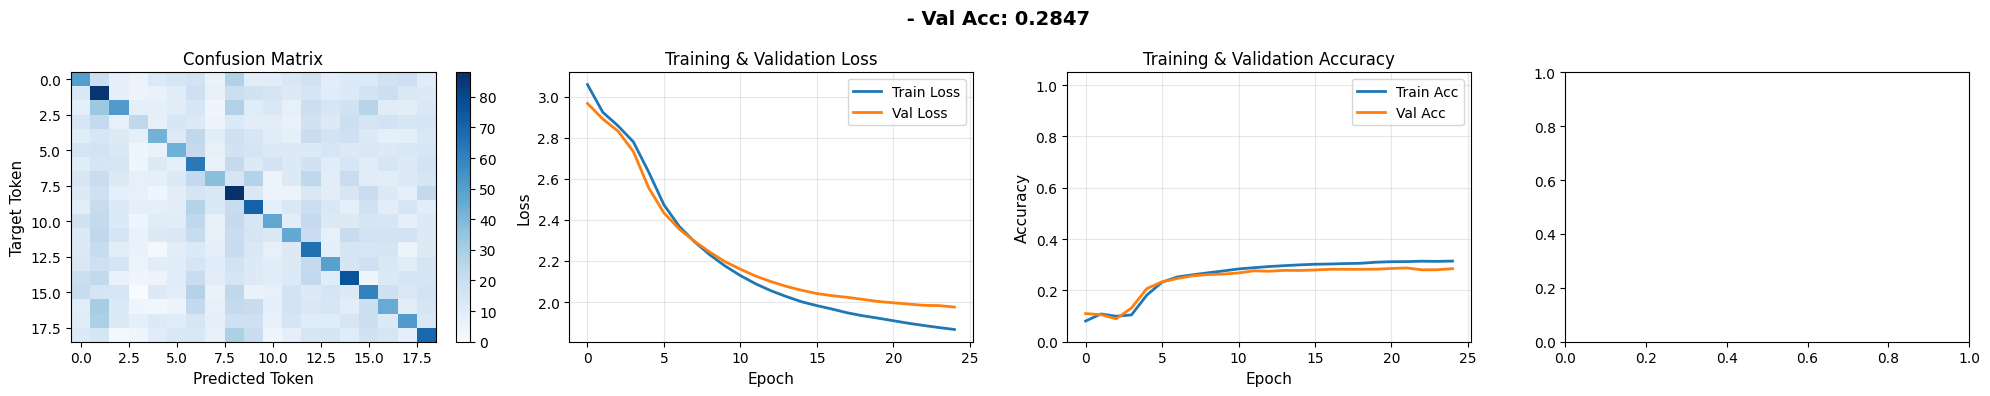

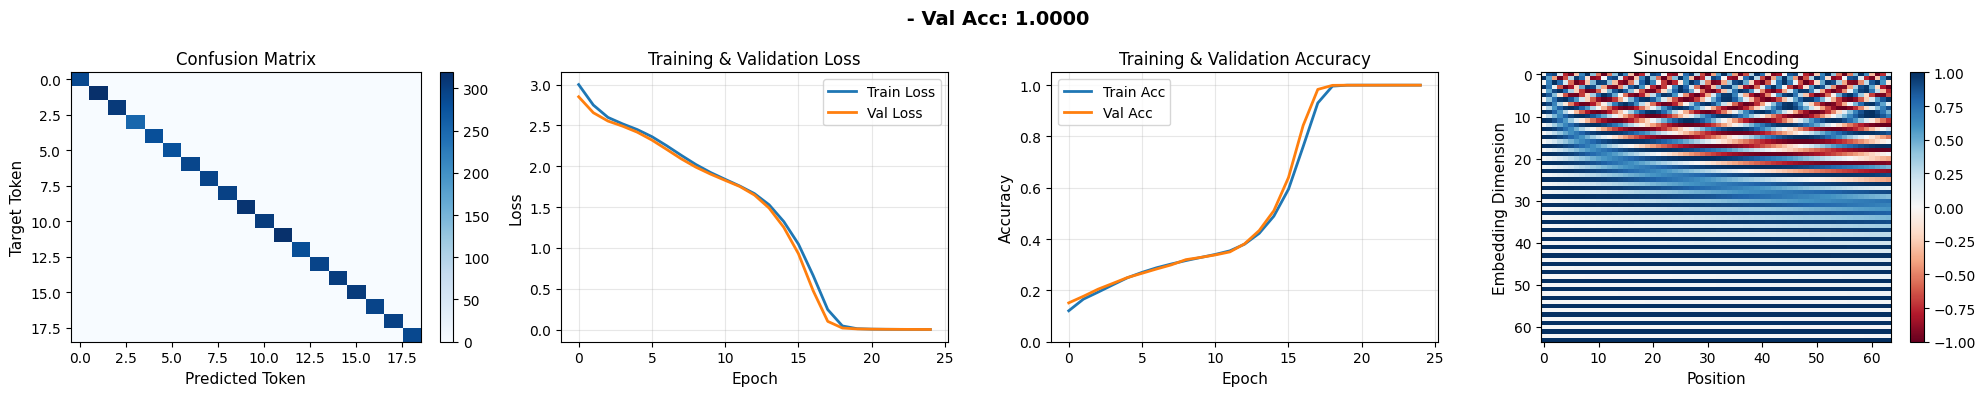

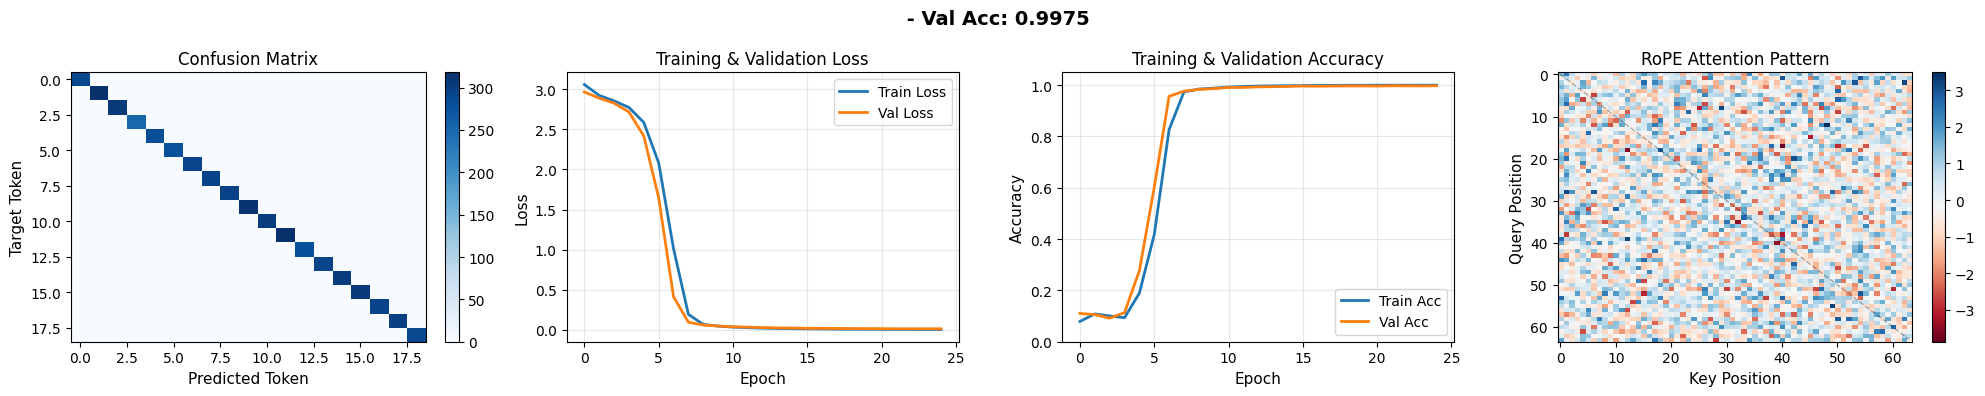

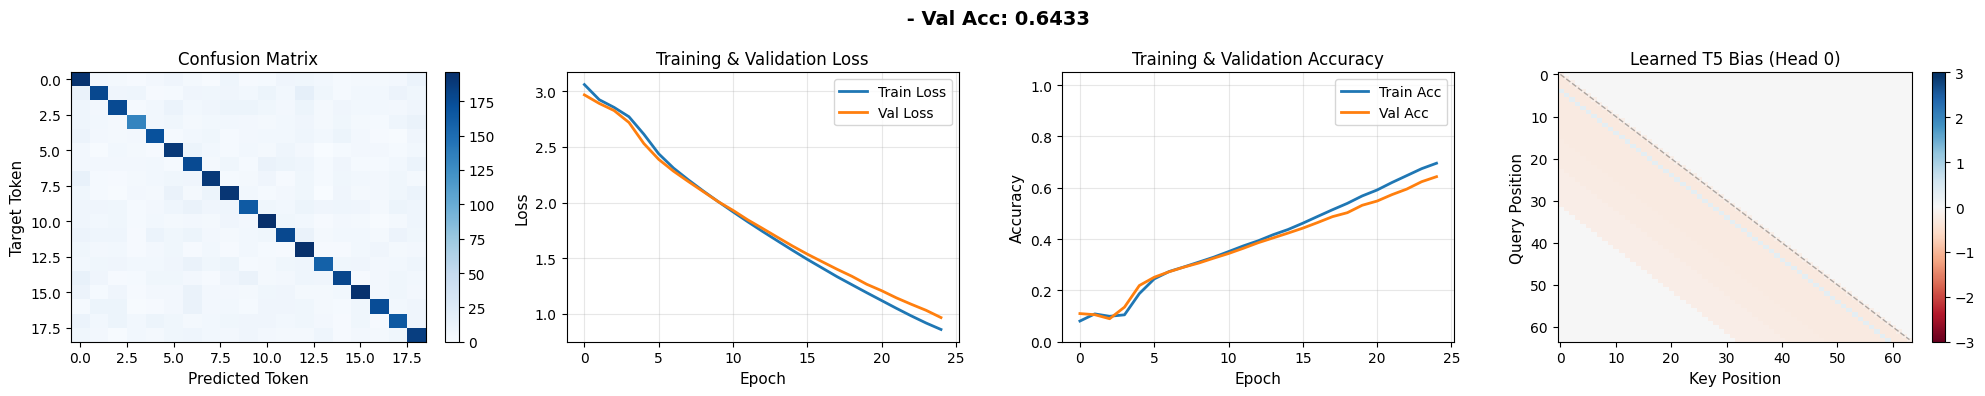

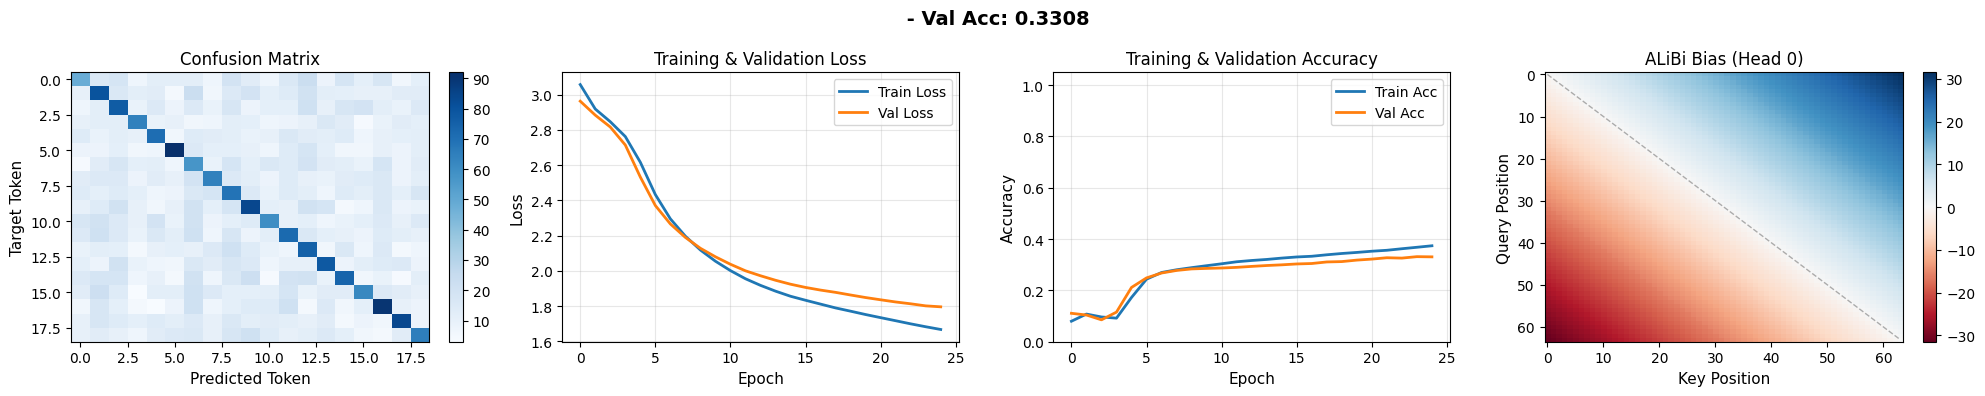

In [12]:
# don't change,
args = {
    "lr": 3e-4,
    "d_model": 64,
    "nhead": 8,
    "batch_size": 32,
    "num_epochs": 25,
    "gradient_clip_val": 1.0,
}

if __name__ == "__main__":
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Configuration
    set_seed()
    data = ShiftDataset(
        data_args["num_samples"],
        data_args["seq_len"],
        data_args["vocab_size"],
        data_args["distance"],
    )
    for positional_encoding_type in ["none", "sinusoidal", "rope", "t5", "alibi"]:
        print("=" * 30 + positional_encoding_type + "=" * 30)
        set_seed()
        model = TinyTransformer(
            data.vocab_size,
            d_model=args["d_model"],
            nhead=args["nhead"],
            num_layers=2,
            max_len=data_args["seq_len"],
            pos_encoding=positional_encoding_type,
            norm_type="rmsnorm",
            pre_norm=True,
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

        trainer = Trainer(
            batch_size=args["batch_size"],
            max_epochs=args["num_epochs"],
            gradient_clip_val=args["gradient_clip_val"],
            device=device,
        )

        trainer.fit(model, data, optimizer)

        visualize_training(
            trainer, data, positional_encoding_type, model, data.vocab_size
        )
plt.show()

(Ungraded)

If you would like, you can experiment with different datasets below.

In [13]:
# don't change
class ReversalDataset(Dataset):
    """
    Reverse the input sequence.

    Input:  [a, b, c, d, e, f, g, h]
    Output: [h, g, f, e, d, c, b, a]

    Requires knowing absolute positions to map position i → position (n-1-i)
    """

    def __init__(self, num_samples=1000, seq_len=16, vocab_size=20):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        src = torch.randint(1, self.vocab_size, (self.seq_len,))
        tgt = torch.flip(src, dims=[0])  # Reverse the sequence

        return {"inputs": src, "targets": tgt}


class PositionDependentDataset(Dataset):
    """
    Each position in the sequence should output a specific token based on position modulo vocab_size.

    Example (vocab_size=10):
    Position:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...]
    Target:    [1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2,  3,  ...]

    Input is random, output depends only on absolute position!
    """

    def __init__(self, num_samples=1000, seq_len=32, vocab_size=10):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Input is random noise
        src = torch.randint(1, self.vocab_size, (self.seq_len,))

        # Target depends ONLY on absolute position
        positions = torch.arange(self.seq_len)
        tgt = (positions % (self.vocab_size - 1)) + 1  # Cycle through 1 to vocab_size-1

        return {"inputs": src, "targets": tgt}


# Part 2 - Architectural Changes - Train

For this part of the assignment we will use a different dataset, where we sort the numbers. There is actually nothing to change here (you have completed this part when implementing the architecture and norm layers) but make sure that your implementation is correct.

In [14]:
class SortingDataset(Dataset):
    """
    Sort sequences
    """

    def __init__(self, num_samples=1000, seq_len=32, vocab_size=20):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        src = torch.randint(1, self.vocab_size, (self.seq_len,))
        tgt = torch.sort(src)[0]

        return {"inputs": src, "targets": tgt}

==============================rmsnorm - Pre-LN - rope==============================
Epoch 5 train loss: 2.81620,	 train acc: 0.12324
	validation loss 2.72968, val acc: 0.14359 
Epoch 10 train loss: 1.67671,	 train acc: 0.35082
	validation loss 1.68841, val acc: 0.35563 
Epoch 15 train loss: 1.50597,	 train acc: 0.40238
	validation loss 1.49002, val acc: 0.39734 
Epoch 20 train loss: 1.44036,	 train acc: 0.42660
	validation loss 1.42818, val acc: 0.42922 
Epoch 25 train loss: 1.39306,	 train acc: 0.44250
	validation loss 1.39464, val acc: 0.45844 
==============================rmsnorm - Post-LN - rope==============================
Epoch 5 train loss: 2.83682,	 train acc: 0.11203
	validation loss 2.76900, val acc: 0.13625 
Epoch 10 train loss: 1.83082,	 train acc: 0.33102
	validation loss 1.79911, val acc: 0.34063 
Epoch 15 train loss: 1.56923,	 train acc: 0.39848
	validation loss 1.53796, val acc: 0.40625 
Epoch 20 train loss: 1.46089,	 train acc: 0.42629
	validation loss 1.45307, val a

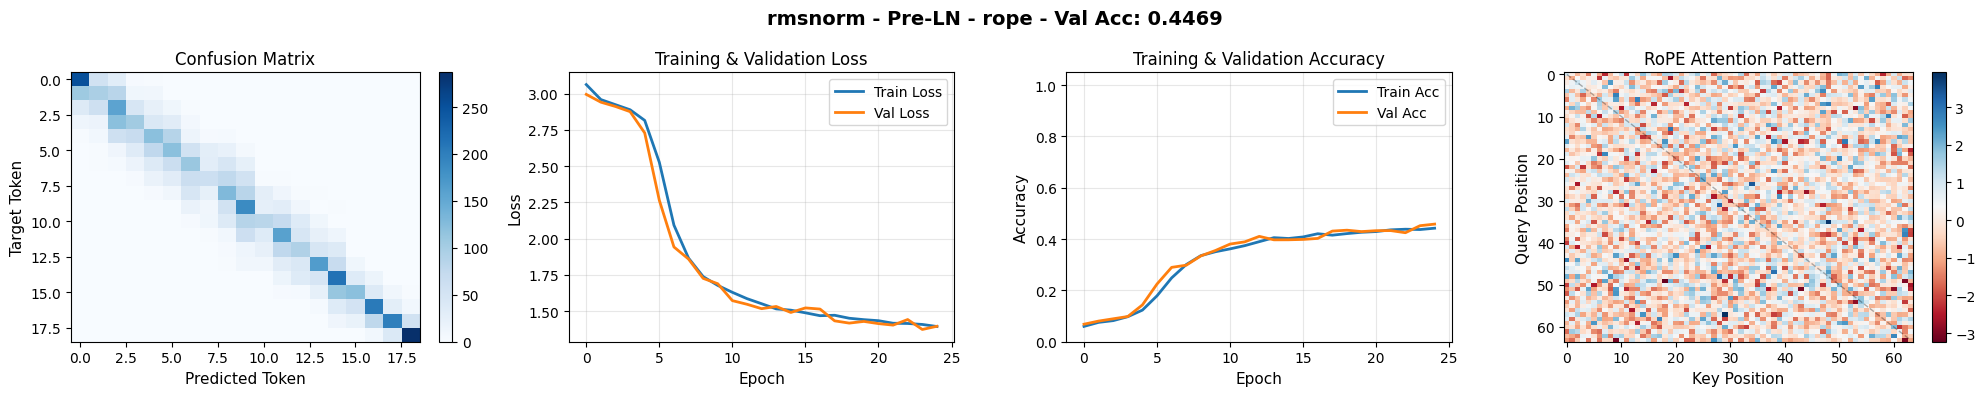

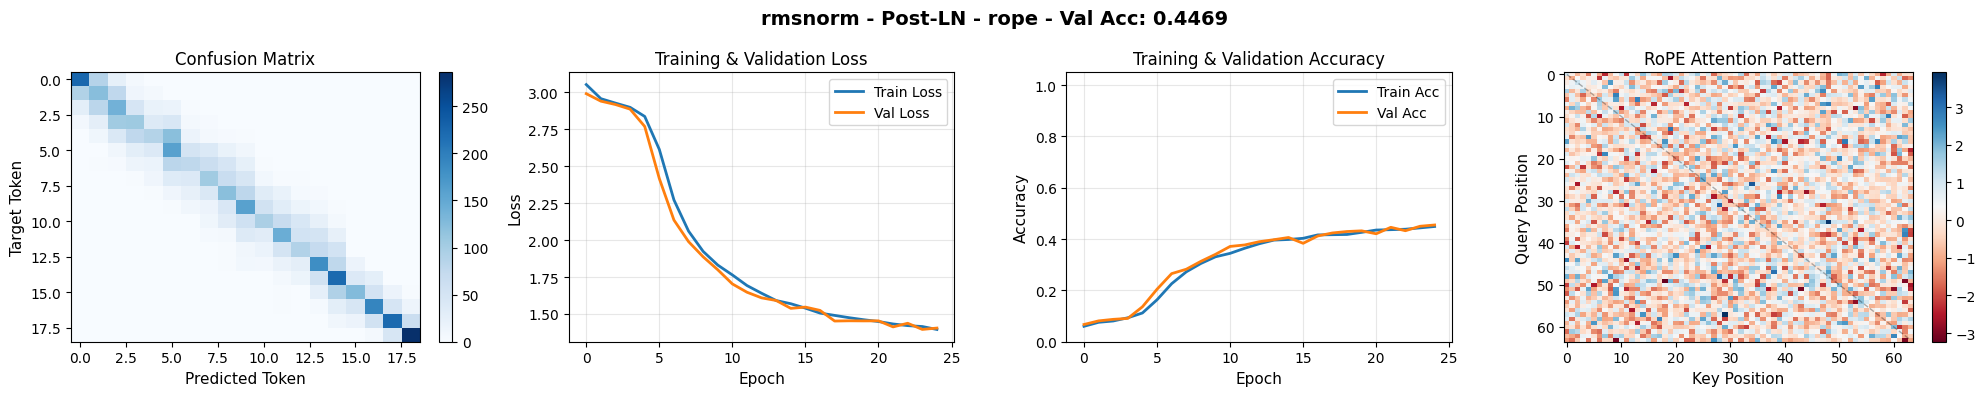

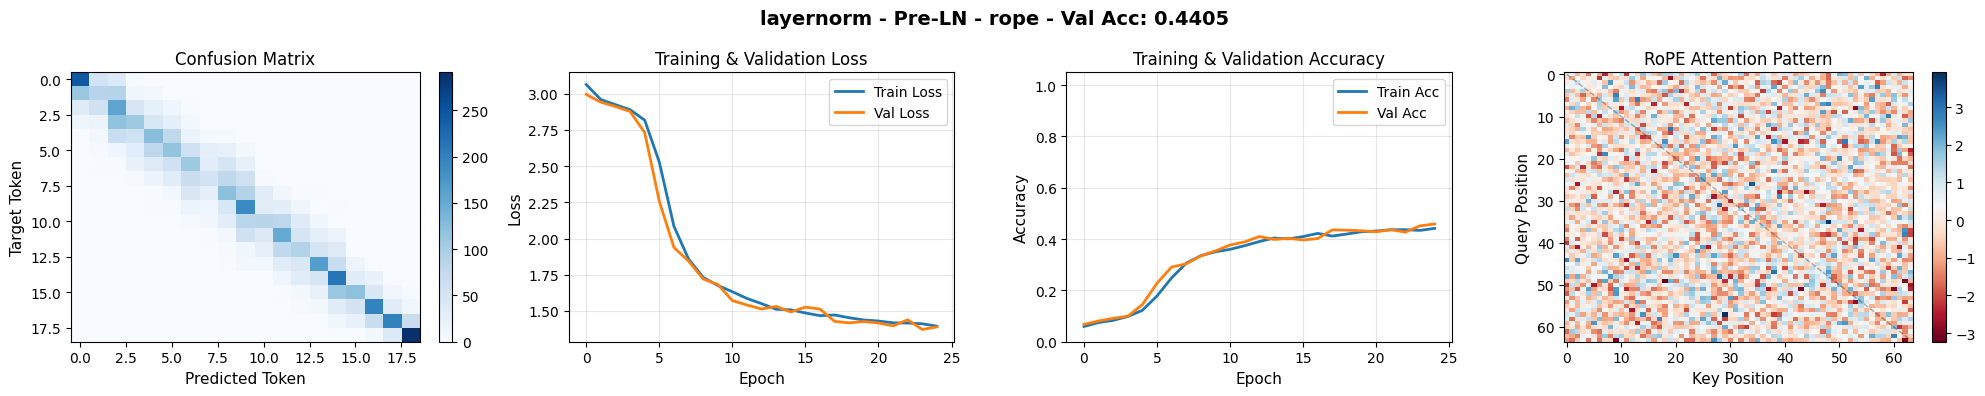

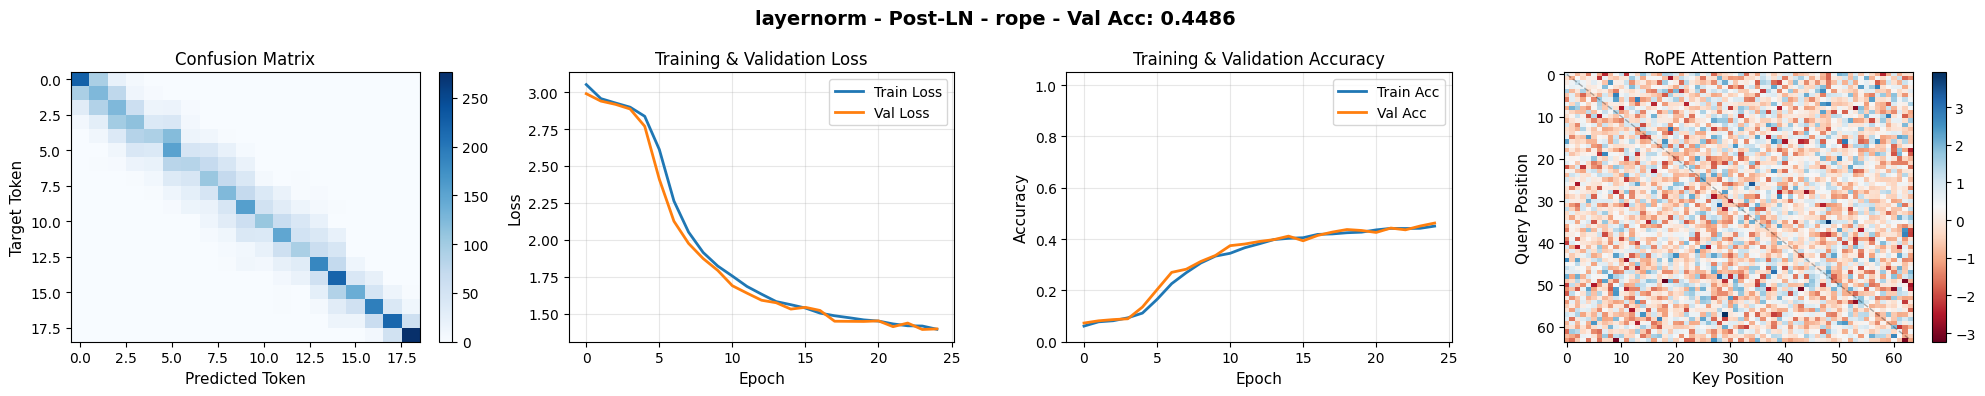

In [15]:
# don't change
if __name__ == "__main__":
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Configuration
    set_seed()
    data = SortingDataset(
        data_args["num_samples"], data_args["seq_len"], data_args["vocab_size"]
    )
    for norm_type in ["rmsnorm", "layernorm"]:
        for pre_norm in [True, False]:
            positional_encoding_type = "rope"
            # for positional_encoding_type in ["sinusoidal", "rope", "t5", "alibi"]:
            title = "Pre-LN" if pre_norm else "Post-LN"
            title = f"{norm_type} - {title} - {positional_encoding_type}"
            print("=" * 30 + title + "=" * 30)
            set_seed()
            model = TinyTransformer(
                data.vocab_size,
                d_model=args["d_model"],
                nhead=args["nhead"],
                num_layers=2,
                max_len=data_args["seq_len"],
                pos_encoding=positional_encoding_type,
                norm_type=norm_type,
                pre_norm=pre_norm,
            )
            optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

            trainer = Trainer(
                batch_size=args["batch_size"],
                max_epochs=args["num_epochs"],
                gradient_clip_val=args["gradient_clip_val"],
                device=device,
            )

            trainer.fit(model, data, optimizer)

            visualize_training(trainer, data, positional_encoding_type, model, data.vocab_size, title)
plt.show()

# Part 3 - Architecture Detective (2 Points)

In this part of the homework you will play the architecture detective for five mystery models. These models are/were popular models of NLP. We standardized their state dicts. Your task is to determine the following information about each model looking at their state_dicts.

It might look like:
```python
{
  "vocab_size": 20, # int
  "d_model": 12, # int
  "ffn_size": 32, # int
  "num_hidden_layers": 2, # int
  "norm_type": "rmsnorm", # "layernorm" or "rmsnorm"
  "attention_type": "mha", # "mha" (for multi-head attention) or "gqa" (for grouped-query attention)
  "is_gated": False,
  "is_tied_embeddings": False,
  "decoder_only": False,
}
```

If you are curious and want to go the extra mile you can also try to match the model architectures to their source.

## General Hints:
At this point in the class you should be familiar with most of these terms and be able to identify them by looking at the state_dicts.

- `is_tied_embeddings`: for small models, we might tie (share) the input and output embeddings. [True or False]
- `is_gated`: indicates that the feed-forward network includes an additional linear layer
  to gate activations (e.g., GEGLU, SwiGLU). [True or False]
- `decoder_only`: True if the model follows a decoder-only architecture, False if it is an encoder-decoder model.


  The models are listed below:
  - 0: https://huggingface.co/r-three/mystery-model-0/blob/main/model.safetensors
  - 1: https://huggingface.co/r-three/mystery-model-1/blob/main/model.safetensors
  - 2: https://huggingface.co/r-three/mystery-model-2/blob/main/model.safetensors
  - 3: https://huggingface.co/r-three/mystery-model-3/blob/main/model.safetensors
  - 4: https://huggingface.co/r-three/mystery-model-4/blob/main/model.safetensors

In [16]:

default_model_dct = {
    "vocab_size": 0,
    "d_model": 0,
    "ffn_size": 0,
    "num_hidden_layers": 0,
    # "layernorm or rmsnorm"
    "norm_type": "",
    # attention_type should be "mha (multi-head) or gqa (grouped-query)",
    "attention_type":  "",
    # is_gated, is_tied_embeddings, and decoder_only should be boolean
    "is_gated": None,
    "is_tied_embeddings": None,
    "decoder_only": None,
}

def type_check(model_dct):
    assert all([k in default_model_dct.keys() for k in model_dct.keys()]), "Don't add additional keys"
    assert all([k in model_dct.keys() for k in default_model_dct.keys()]), "Don't miss any keys"
    assert isinstance(model_dct["vocab_size"], int), "vocab_size should be an integer"
    assert isinstance(model_dct["d_model"], int), "d_model should be an integer"
    assert isinstance(model_dct["ffn_size"], int), "ffn_size should be an integer"
    assert isinstance(model_dct["num_hidden_layers"], int), "num_hidden_layers should be an integer"
    assert model_dct["norm_type"] in ["layernorm", "rmsnorm"]
    assert model_dct["attention_type"] in ["mha", "gqa"]
    assert isinstance(model_dct["is_gated"], bool), "is_gated should be a boolean"
    assert isinstance(model_dct["is_tied_embeddings"], bool), "is_tied_embeddings should be a boolean"
    assert isinstance(model_dct["decoder_only"], bool), "decoder_only should be a boolean"



In [25]:
def mystery_model_0():
    res = default_model_dct.copy()  # Important: use .copy() to avoid modifying the default!
    ########################### YOUR CODE ###################################
    res["vocab_size"] = 128256  # TODO: Get from embedding layer shape
    res["d_model"] = 2048  # TODO: Get from embedding layer shape
    res["ffn_size"] = 8192  # TODO: Get from FFN layer shape
    res["num_hidden_layers"] = 16  # TODO: Count layer indices
    res["norm_type"] = "rmsnorm"  # TODO: "layernorm" or "rmsnorm"
    res["attention_type"] = "gqa"  # TODO: "mha" or "gqa"
    res["is_gated"] = True  # TODO: Check for gate projection
    res["is_tied_embeddings"] = True  # TODO: Check if lm_head exists
    res["decoder_only"] = True  # TODO: Check for encoder/decoder structure
    #########################################################################
    return res

def mystery_model_1():
    res = default_model_dct.copy()
    ########################### YOUR CODE ###################################
    res["vocab_size"] = 262144
    res["d_model"] = 1152
    res["ffn_size"] = 6912
    res["num_hidden_layers"] = 26
    res["norm_type"] = "rmsnorm"
    res["attention_type"] = "gqa"
    res["is_gated"] = True
    res["is_tied_embeddings"] = True
    res["decoder_only"] = True
    #########################################################################
    return res

def mystery_model_2():
    res = default_model_dct.copy()
    ########################### YOUR CODE ###################################
    res["vocab_size"] = 50304
    res["d_model"] = 512
    res["ffn_size"] = 2048
    res["num_hidden_layers"] = 6
    res["norm_type"] = "layernorm"
    res["attention_type"] = "mha"
    res["is_gated"] = False
    res["is_tied_embeddings"] = False
    res["decoder_only"] = True
    #########################################################################
    return res

def mystery_model_3():
    res = default_model_dct.copy()
    ########################### YOUR CODE ###################################
    res["vocab_size"] = 32128
    res["d_model"] = 768
    res["ffn_size"] = 3072
    res["num_hidden_layers"] = 12
    res["norm_type"] = "rmsnorm"
    res["attention_type"] = "mha"
    res["is_gated"] = False
    res["is_tied_embeddings"] = True
    res["decoder_only"] = False
    #########################################################################
    return res

def mystery_model_4():
    res = default_model_dct.copy()
    ########################### YOUR CODE ###################################
    res["vocab_size"] = 32768
    res["d_model"] = 4096
    res["ffn_size"] = 14336
    res["num_hidden_layers"] = 32
    res["norm_type"] = "rmsnorm"
    res["attention_type"] = "gqa"
    res["is_gated"] = True
    res["is_tied_embeddings"] = False
    res["decoder_only"] = True
    #########################################################################
    return res

In [26]:
if __name__ == "__main__":
    type_check(mystery_model_0())
    type_check(mystery_model_1())
    type_check(mystery_model_2())
    type_check(mystery_model_3())
    type_check(mystery_model_4())

# Collaboration / External Help
Disclose any help you used (LLM usage, blogs, search, Github links, etc) and collaborations with your classmates. If you  completed the homework on your own, you can leave this part empty.

> TODO